# 4.1 Explanation Continuity

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import nn_ops, gen_nn_ops
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import numpy as np

from models.models_4_1 import MNIST_CNN, Taylor
from utils import translate

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/4_1_EQ/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('DTD', X)
    
    for activation in activations:
        tf.add_to_collection('DTD', activation)
    
    tf.add_to_collection('SA_STD', X)
    tf.add_to_collection('SA_STD', logits)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.166183108 accuracy = 0.947363642
Epoch: 0002 cost = 0.044496261 accuracy = 0.986781827
Epoch: 0003 cost = 0.029138031 accuracy = 0.990672735
Epoch: 0004 cost = 0.022342106 accuracy = 0.992672734
Epoch: 0005 cost = 0.016914875 accuracy = 0.994436369
Epoch: 0006 cost = 0.014987342 accuracy = 0.994890914
Epoch: 0007 cost = 0.013461443 accuracy = 0.995527277
Epoch: 0008 cost = 0.008795333 accuracy = 0.996927276
Epoch: 0009 cost = 0.009626083 accuracy = 0.996854548
Epoch: 0010 cost = 0.007642976 accuracy = 0.997581820
Epoch: 0011 cost = 0.008112480 accuracy = 0.997290912
Epoch: 0012 cost = 0.007751439 accuracy = 0.997527275
Epoch: 0013 cost = 0.006631166 accuracy = 0.997781820
Epoch: 0014 cost = 0.006926514 accuracy = 0.997581820
Epoch: 0015 cost = 0.004724893 accuracy = 0.998418183
Accuracy: 0.9922


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the `tf.get_collection()` function.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

INFO:tensorflow:Restoring parameters from ./tf_logs/4_1_EQ/model


### 5. Attaching Subgraph for Calculating Relevance Scores

In [5]:
conv_ksize = [1, 3, 3, 1]
pool_ksize = [1, 2, 2, 1]
conv_strides = [1, 1, 1, 1]
pool_strides = [1, 2, 2, 1]

activations = tf.get_collection('DTD')
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='CNN')

taylor = Taylor(activations, weights, conv_ksize, pool_ksize, conv_strides, pool_strides, 'Taylor')

Rs = [taylor(i) for i in range(10)]

nodes = tf.get_collection('SA_STD')
X = nodes[0]
logits = nodes[1]

gradients = [tf.gradients(logits[0][i], X) for i in range(10)]
STD_scores = [tf.multiply(tf.gradients(logits[0][i], X), X) for i in range(10)]

### 6. Calculating Relevance Scores $R(x_i)$ and Displaying Images

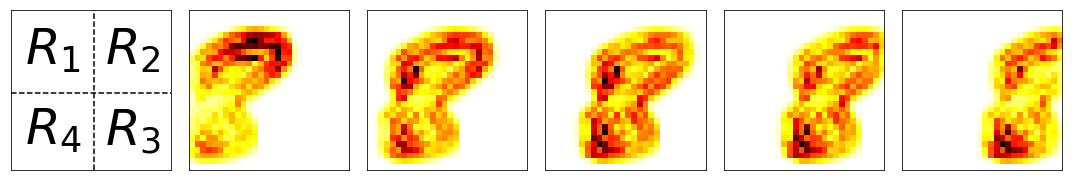

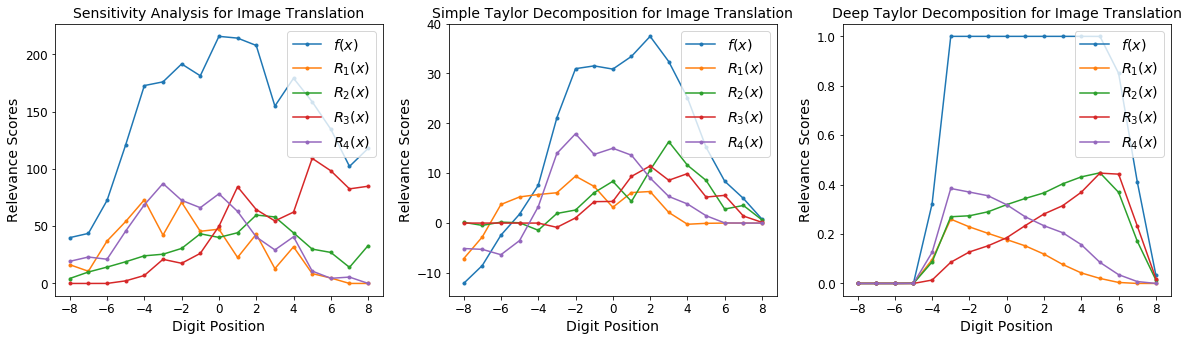

In [6]:
digit = 8
dist = 17
init = -8

images = mnist.train.images
labels = mnist.train.labels
sample_imgs = [images[np.argmax(labels, axis=1) == i][3] for i in range(10)]
translated_imgs = [[translate(img, init + i, 0) for i in range(dist)] for img in sample_imgs]

sa_imgs = [[sess.run(gradients[i], feed_dict={X:translated_imgs[i][j]}) for j in range(dist)] for i in range(10)]
sa_imgs = np.square(np.reshape(sa_imgs, [10, dist, -1]))

std_imgs = [[sess.run(STD_scores[i], feed_dict={X:translated_imgs[i][j]}) for j in range(dist)] for i in range(10)]
std_imgs = np.reshape(std_imgs, [10, dist, -1])

dtd_imgs = [[sess.run(Rs[i], feed_dict={X:translated_imgs[i][j]}) for j in range(dist)] for i in range(10)]
dtd_imgs = np.squeeze(dtd_imgs, axis=2)

sa_imgs_q0 = sa_imgs[digit]
sa_imgs_q1 = sa_imgs[digit].reshape(dist,28,28)[:,0:14,0:14].reshape(dist,-1)
sa_imgs_q2 = sa_imgs[digit].reshape(dist,28,28)[:,0:14,14:28].reshape(dist,-1)
sa_imgs_q3 = sa_imgs[digit].reshape(dist,28,28)[:,14:28,14:28].reshape(dist,-1)
sa_imgs_q4 = sa_imgs[digit].reshape(dist,28,28)[:,14:28,0:14].reshape(dist,-1)

std_imgs_q0 = std_imgs[digit]
std_imgs_q1 = std_imgs[digit].reshape(dist,28,28)[:,0:14,0:14].reshape(dist,-1)
std_imgs_q2 = std_imgs[digit].reshape(dist,28,28)[:,0:14,14:28].reshape(dist,-1)
std_imgs_q3 = std_imgs[digit].reshape(dist,28,28)[:,14:28,14:28].reshape(dist,-1)
std_imgs_q4 = std_imgs[digit].reshape(dist,28,28)[:,14:28,0:14].reshape(dist,-1)

dtd_imgs_q0 = dtd_imgs[digit]
dtd_imgs_q1 = dtd_imgs[digit].reshape(dist,28,28)[:,0:14,0:14].reshape(dist,-1)
dtd_imgs_q2 = dtd_imgs[digit].reshape(dist,28,28)[:,0:14,14:28].reshape(dist,-1)
dtd_imgs_q3 = dtd_imgs[digit].reshape(dist,28,28)[:,14:28,14:28].reshape(dist,-1)
dtd_imgs_q4 = dtd_imgs[digit].reshape(dist,28,28)[:,14:28,0:14].reshape(dist,-1)

fig = plt.figure(figsize=[15,15])
for i in range(6):
    if i is 0:
        ax = fig.add_subplot(1, 6, 1)
        ax.imshow(np.zeros([28,28]), cmap='gray_r', vmin=0, vmax=1)
        ax.tick_params(labelbottom='off', labelleft='off', bottom='off', left='off')
        ax.axvline(14, linestyle='--', color='black')
        ax.axhline(14, linestyle='--', color='black')
        ax.text(2, 9, '$R_1$', fontdict={'fontsize': 50})
        ax.text(16, 9, '$R_2$', fontdict={'fontsize': 50})
        ax.text(16, 23, '$R_3$', fontdict={'fontsize': 50})
        ax.text(2, 23, '$R_4$', fontdict={'fontsize': 50})
        continue
        
    ax = fig.add_subplot(1, 6, i + 1)
    ax.imshow(dtd_imgs_q0[4 * (i - 1)].reshape([28,28]), cmap='hot_r')
    ax.tick_params(labelbottom='off', labelleft='off', bottom='off', left='off')
plt.tight_layout()

fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(131)
x = list(range(init,init+dist))
y0 = np.sum(sa_imgs_q0, axis=1)
y1 = np.sum(sa_imgs_q1, axis=1)
y2 = np.sum(sa_imgs_q2, axis=1)
y3 = np.sum(sa_imgs_q3, axis=1)
y4 = np.sum(sa_imgs_q4, axis=1)

ax1.plot(x, y0, marker='.', label='$f(x)$')
ax1.plot(x, y1, marker='.', label='$R_1(x)$')
ax1.plot(x, y2, marker='.', label='$R_2(x)$')
ax1.plot(x, y3, marker='.', label='$R_3(x)$')
ax1.plot(x, y4, marker='.', label='$R_4(x)$')
ax1.legend(loc='upper right', fontsize='x-large')

ax1.set_title('Sensitivity Analysis for Image Translation', fontdict={'fontsize': 14})
ax1.set_xlabel('Digit Position', fontdict={'fontsize': 14})
ax1.set_ylabel('Relevance Scores', fontdict={'fontsize': 14})
ax1.tick_params(labelsize=12)

ax2 = fig.add_subplot(132)
y0 = np.sum(std_imgs_q0, axis=1)
y1 = np.sum(std_imgs_q1, axis=1)
y2 = np.sum(std_imgs_q2, axis=1)
y3 = np.sum(std_imgs_q3, axis=1)
y4 = np.sum(std_imgs_q4, axis=1)

ax2.plot(x, y0, marker='.', label='$f(x)$')
ax2.plot(x, y1, marker='.', label='$R_1(x)$')
ax2.plot(x, y2, marker='.', label='$R_2(x)$')
ax2.plot(x, y3, marker='.', label='$R_3(x)$')
ax2.plot(x, y4, marker='.', label='$R_4(x)$')
ax2.legend(loc='upper right', fontsize='x-large')

ax2.set_title('Simple Taylor Decomposition for Image Translation', fontdict={'fontsize': 14})
ax2.set_xlabel('Digit Position', fontdict={'fontsize': 14})
ax2.set_ylabel('Relevance Scores', fontdict={'fontsize': 14})
ax2.tick_params(labelsize=12)

ax3 = fig.add_subplot(133)
y0 = np.sum(dtd_imgs_q0, axis=1)
y1 = np.sum(dtd_imgs_q1, axis=1)
y2 = np.sum(dtd_imgs_q2, axis=1)
y3 = np.sum(dtd_imgs_q3, axis=1)
y4 = np.sum(dtd_imgs_q4, axis=1)

ax3.plot(x, y0, marker='.', label='$f(x)$')
ax3.plot(x, y1, marker='.', label='$R_1(x)$')
ax3.plot(x, y2, marker='.', label='$R_2(x)$')
ax3.plot(x, y3, marker='.', label='$R_3(x)$')
ax3.plot(x, y4, marker='.', label='$R_4(x)$')
ax3.legend(loc='upper right', fontsize='x-large')

ax3.set_title('Deep Taylor Decomposition for Image Translation', fontdict={'fontsize': 14})
ax3.set_xlabel('Digit Position', fontdict={'fontsize': 14})
ax3.set_ylabel('Relevance Scores', fontdict={'fontsize': 14})
ax3.tick_params(labelsize=12)

sess.close()